In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier

import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import levene, ttest_ind, chi2_contingency, fisher_exact, shapiro, kstest

import warnings
warnings.filterwarnings('ignore')

#### Kaggle Dataset Link: https://www.kaggle.com/mandalravi/loan-prediction-data

#### Steps:

1. **Data Preprocessing:** In order to focus on fairness aspects of model, we will do minimalistic data preprocessing.
2. **Cross-Validation Framework:** Stratified KFold since the data is class-imbalanced.
3. **Model Training:** LGBM
4. **Model Prediction:** Predictions on test set
5. **Fairness Testing:** Statistical tests

In [2]:
train = pd.read_csv('fairness_dataset/train.csv')
test = pd.read_csv('fairness_dataset/test.csv')
test['Loan_Status'] = -1
data = pd.concat([train, test])
data.shape, train.shape, test.shape

((981, 13), (614, 13), (367, 13))

In [3]:
data.dropna(inplace=True)

categorical_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']
for col in categorical_columns:
    ohe = OneHotEncoder()
    data[ohe.get_feature_names_out()] = ohe.fit_transform(data[[col]]).toarray()
    data.drop(columns=col, inplace=True)

In [4]:
train = data[data['Loan_Status']!=-1]
test = data[data['Loan_Status']==-1]

cols = data.columns.tolist()
cols.remove('Loan_ID')
cols.remove('Loan_Status')

X = train[cols].values
y = train['Loan_Status'].values
y = np.where(y=='Y', 1, 0)
X_test = test[cols].values

#### Evaluation Metric:

The model predicts the probability of giving a loan to applicant or not. Class 1 for 'Yes' and 0 for 'No'. Based on outcomes, we can have the following two costs:

1. **False Positive:** Giving a loan to someone when they should not have been. This can be costly as the applicant can default. 

2. **False Negative:** Not giving a loan to someone when they should have been. This makes us lose opportunity cost.

As per business scenarios, either of the above two costs can be costlier than other and accordingly, Precision or Recall can be taken as target metric for optimizing loan prediction ability. However, since both the costs are important in general, we will consider **F1 Score** as optimizing metric.

In [5]:
y_pred = np.zeros(shape=(len(y)))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for train_index, val_index in skf.split(X, y):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    clf = LGBMClassifier()
    clf.fit(X_train, y_train)
    y_pred[val_index] = clf.predict(X_val)

print('F1 Score:', f1_score(y, y_pred))

F1 Score: 0.8431654676258994


In [6]:
clf.fit(X, y)
y_pred_test = clf.predict(X_test)
test.loc[:, 'Loan_Status'] = y_pred_test
submit = test.loc[:, ['Loan_ID', 'Loan_Status']]

test = pd.read_csv('fairness_dataset/test.csv')
test = pd.merge(test, submit, how='inner', on='Loan_ID').reset_index(drop=True)

### Fairness Testing in Models

Now, we will look at whether our model is biased towards certain factors while giving loans or not.
Since our target variable is categorical, there can be following types of tests:
1. Categorical (Target) v/s Categorical (Dependent):
    1. Contingency Table
    2. Chi-square test
2. Categorical (Target) v/s Numeric (Dependent):
    1. T-Test:
        1. If class samples are coming from populations of similar variances:
            1. Pooled T-Test
        2. Else:
            1. Welch T-Test

In [7]:
significance_level = 0.05

In [8]:
test0 = test[test['Loan_Status']==0]
test1 = test[test['Loan_Status']==1]

print('Number of loan applicants to be given loan as per model predictions: ', len(test0))
print('Number of loan applicants not to be given loan as per model predictions: ', len(test1))

Number of loan applicants to be given loan as per model predictions:  74
Number of loan applicants not to be given loan as per model predictions:  215


We notice that sample sizes are different. For performing a t-test, the test statistic is supposed to follow Student's t distribution which is ratio of Standard Normal variate to Chi-Square variate.

In [9]:
def ttest(*args, **kwargs):
    center = kwargs['center']
    significance_level = kwargs['significance_level']
    
    # check homogeneity of variances
    # center represents appropriate function to use for test
    t_stat, p_value = levene(*args, center=center)
    if p_value < significance_level:
        # null hypothesis rejected 
        # samples coming from populations with different variances
        # Welch t-test
        print('Unequal variances')
        t_stat, p_value = ttest_ind(*args, equal_var=False)
    else:
        # null hypothesis failed to reject
        # samples coming from populations with similar variances
        # Pooled t-test
        print('Equal variances')
        t_stat, p_value = ttest_ind(*args, equal_var=True)
    return p_value

In [10]:
def conclusion(label, p_value, significance_level):
    print('P-Value: ', p_value)

    if p_value < significance_level:
        # null hypothesis rejected
        # data is statistically different
        print(f'Model biased towards {label}')
    else:
        # null hypothesis failed to reject
        # data is not statistically different
        print(f'Model not biased towards {label}')

### Fairness Metrics

Definitions:
1. r1: Ratio of positive proportion among unprivileged group.
2. r2: Ratio of positive proportion among privileged group.
3. p1: P(x is in protected set | y=1)
4. p2: P(x is not in protected set | y=1)

Metrics:
1. **Disparate Impact (DI):** r1 / r2, Ideal value = 1 
2. **Difference in positive proportions of predicted labels (DPPL):** r1 - r2, Ideal value = 0
3. **Statistical Parity:** p1 - p2

**Positive Bias:** DI > 1 or DPPL > 0

**Negative Bias:** DI < 1 or DPPL < 0

In [11]:
pd.crosstab(test['Gender'], test['Loan_Status'])

Loan_Status,0,1
Gender,,
Female,20,39
Male,54,176


In [12]:
rate_female = np.sum((test['Gender']=='Female') & (test['Loan_Status']==1)) / np.sum(test['Gender']=='Female')
rate_male = np.sum((test['Gender']=='Male') & (test['Loan_Status']==1)) / np.sum(test['Gender']=='Male')
p1 = np.sum((test['Gender']=='Female') & (test['Loan_Status']==1)) / np.sum(test['Loan_Status']==1)
p2 = np.sum((test['Gender']=='Male') & (test['Loan_Status']==1)) / np.sum(test['Loan_Status']==1)

DI = rate_female / rate_male
DPPL = rate_female - rate_male
SP = p1 - p2

print('DI:', DI)
print('DPPL:', DPPL)
print('Statistical Parity:', p1 - p2)

DI: 0.8638289676425269
DPPL: -0.10420044215180546
Statistical Parity: -0.6372093023255814


DI and DPPL indicate that there is negative bias towards females. SP indicates that males have higher chance of being detected than females.

#### Bias towards Gender

In [13]:
contingency_table = pd.crosstab(test['Gender'], test['Loan_Status']).values

if np.min(contingency_table) < 5:
    # perform Fisher's Exact Test
    print("Fisher's Exact Test")
    odds_ratio, p_value = fisher_exact(contingency_table)
else:
    # perform Pearson's Chi-Square Test
    print('Chi-Square Test')
    chi2_stat, p_value, dof, expected_values = chi2_contingency(contingency_table)

conclusion('Gender', p_value, significance_level)

Chi-Square Test
P-Value:  0.14189259641142235
Model not biased towards Gender


#### Bias towards Applicant Income

We start by checking whether the sample is coming from normal distribution using normality tests like Shapiro-Wilk Test, Q-Q plot and KS-Test. However, it's not a necessary condition if the sample size is large enough.

In [14]:
data0 = test0['ApplicantIncome'].values
data1 = test1['ApplicantIncome'].values

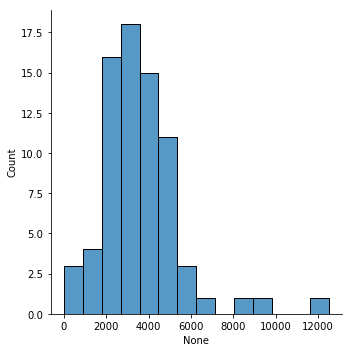

In [15]:
sns.displot(data0)
plt.show()

Performing Shapiro-Wilk Test..
P-Value: 1.4426251482291264e-06
Variable does not follow normal distribution

Performing Kolmogorov-Smirnov Test..
P-Value: 6.6420805605899745e-115
Variable does not follow normal distribution


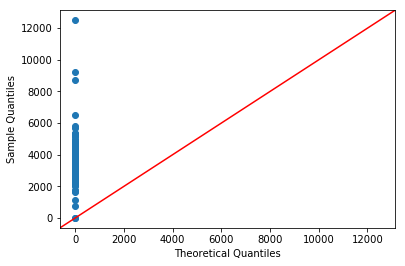

In [16]:
t_stat, p_value = shapiro(data0)
print('Performing Shapiro-Wilk Test..')
print('P-Value:', p_value)
if p_value < significance_level:
    # null hypothesis rejected
    print('Variable does not follow normal distribution')
else:
    # null hypothesis failed to reject
    print('Variable follows normal distribution')

X = np.random.normal(0, 1, 10000)
cdf = []
for x in X:
    p = np.sum(X <= x) / len(X)
    cdf.append(p)

t_stat, p_value = kstest(data0, cdf) 
print('\nPerforming Kolmogorov-Smirnov Test..')
print('P-Value:', p_value)
if p_value < significance_level:
    # null hypothesis rejected
    print('Variable does not follow normal distribution')
else:
    # null hypothesis failed to reject
    print('Variable follows normal distribution')   

sm.qqplot(data0, dist=stats.norm, line='45')
plt.show()

In [17]:
data0 = test0['ApplicantIncome'].values
data1 = test1['ApplicantIncome'].values

p_value = ttest(data0, data1, center = 'mean', significance_level = 0.05)
conclusion('ApplicantIncome', p_value, significance_level)

Equal variances
P-Value:  0.04272472604624704
Model biased towards ApplicantIncome
